# Libraries

In [37]:
import os
import random
import pandas as pd
import numpy as np

# Data Prep
from transformers import AutoTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import nltk
import string

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

from tqdm import tqdm

# Data preparation

## Load data

In [142]:
def score_to_sentiment(score):
    """Convert score to sentiment based on the given convention."""
    if score <= 4:
        return 'negative'
    elif score >= 7:
        return 'positive'
    else:
        return 'neutral'

def load_imdb_data(base_path, sample_size=1000, train=True):
    """Load IMDb data into a pandas DataFrame with balanced sampling."""
    data = []
    categories = ['pos', 'neg']
    sample_per_category = sample_size // 2  # Ensure equal sampling from each category

    for category in categories:
        if train == False: 
            category_path = os.path.join(base_path, 'test', category)
        else:
            category_path = os.path.join(base_path, 'train', category)
        file_paths = [os.path.join(category_path, file_name) for file_name in os.listdir(category_path)]

        # Randomly sample file paths from the current category
        sampled_files = random.sample(file_paths, sample_per_category)

        # Read each file and extract information
        for file_path in sampled_files:
            file_name = os.path.basename(file_path)
            id, score = file_name.split('_')
            score = int(score.replace('.txt', ''))
            sentiment = score_to_sentiment(score)

            with open(file_path, 'r', encoding='utf-8') as file:
                review = file.read()

            data.append({'id': id, 'review': review, 'score': score, 'sentiment': sentiment})

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

In [4]:
base_path = 'aclImdb'  
df = load_imdb_data(base_path, sample_size=2000)
print(df.head())
print(df['sentiment'].value_counts())

      id                                             review  score sentiment
0   8302  Guns blasting, buildings exploding, cars crash...      8  positive
1   4807  I really thought that this movie was superb. N...     10  positive
2  11672  Excellent pirate entertainment! It has all the...     10  positive
3   1540  This is an incredible film. I can't remember t...     10  positive
4  10919  Five Deadly Venoms is not as bloody and violen...     10  positive
sentiment
positive    1000
negative    1000
Name: count, dtype: int64


In [5]:
df.describe()

,score
count,2000.00000
mean,5.51000
std,3.48439
min,1.00000
25%,2.00000
50%,5.50000
75%,9.00000
max,10.00000


In [6]:
# Check for nan values
df.isna().sum()

id           0
review       0
score        0
sentiment    0
dtype: int64

In [7]:
# check for duplicates
df.duplicated().sum()

0

## Data preprocessing

1. Tokenization

Tokenization is the process of breaking down text into individual words or tokens.

2. Stopword Removal

Stopwords are common words that do not contribute much meaning to the text (e.g., "and", "the", "is"). Removing them can help focus on the important words.

3. Stemming/Lemmatization

Stemming: Reduces words to their root form (e.g., "running" to "run").
Lemmatization: Reduces words to their base or dictionary form (e.g., "better" to "good").


In [ ]:
# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Convert Treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if unknown

def preprocess_text(text):
    # Tokenize the text
    #tokens = tokenizer.tokenize(text)
    tokens = word_tokenize(text.lower()) #NLTK

    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]

    # POS tagging
    pos_tags = pos_tag(tokens)

    # Lemmatize the tokens using POS tags
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    return lemmatized_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
df['processed_review'] = df['review'].apply(lambda x: ' '.join(preprocess_text(x)))
df.head()

,id,review,score,sentiment,processed_review
0,8302,"Guns blasting, buildings exploding, cars crash...",8,positive,gun blast building explode car crash 's first ...
1,4807,I really thought that this movie was superb. N...,10,positive,really thought movie superb history correct st...
2,11672,Excellent pirate entertainment! It has all the...,10,positive,excellent pirate entertainment good ingredient...
3,1540,This is an incredible film. I can't remember t...,10,positive,incredible film ca n't remember last time saw ...
4,10919,Five Deadly Venoms is not as bloody and violen...,10,positive,five deadly venom bloody violent story ricky s...


# Feature Extraction

1. TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents. 

https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/

In [11]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

2. Word2Vec

Word2Vec is a neural network-based model that learns word embeddings by predicting the context of words in a sentence. It has two main architectures:

Continuous Bag of Words (CBOW): Predicts a word based on its context (surrounding words).

Skip-gram: Predicts the context words given a target word.

In [12]:
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess

# # Example sentences (replace with your preprocessed reviews)
# sentences = [
#     "This is a sample movie review".split(),
#     "It was amazing and fantastic".split()
# ]

# # Train Word2Vec model
# model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# # Get word vector for a specific word
# word_vector = model.wv['amazing']
# print(word_vector)

# Data Visualization

1. t-SNE (t-Distributed Stochastic Neighbor Embedding) is a technique for dimensionality reduction that is particularly well-suited for visualizing high-dimensional data. It reduces the dimensions while trying to maintain the relative distances between points.

Text(0, 0.5, 't-SNE Component 2')

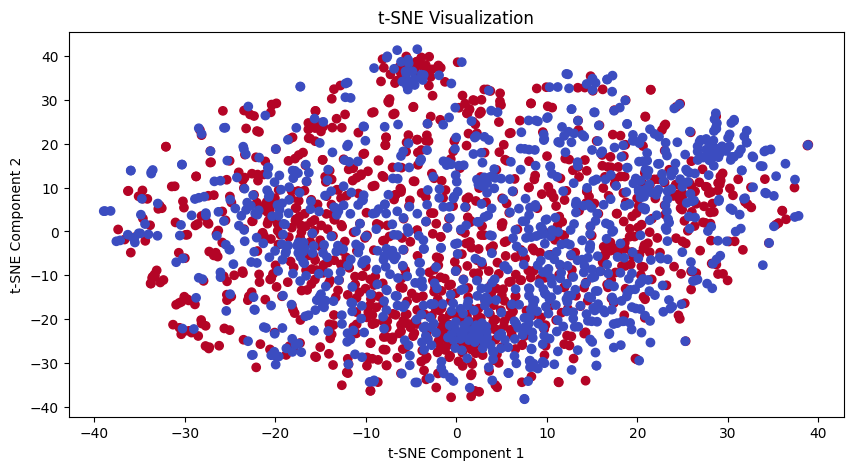

In [17]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# Plot t-SNE results
plt.figure(figsize=(10, 5))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['sentiment'].map({'positive': 1, 'negative': 0}), cmap='coolwarm')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

2. MAP (Uniform Manifold Approximation and Projection)

UMAP is another dimensionality reduction technique that is similar to t-SNE but often preserves more of the global structure of the data and can be faster for large datasets.

/var/folders/hs/jhbbsd052zz044qtbzkkhxl80000gn/T/ipykernel_76080/2276391479.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


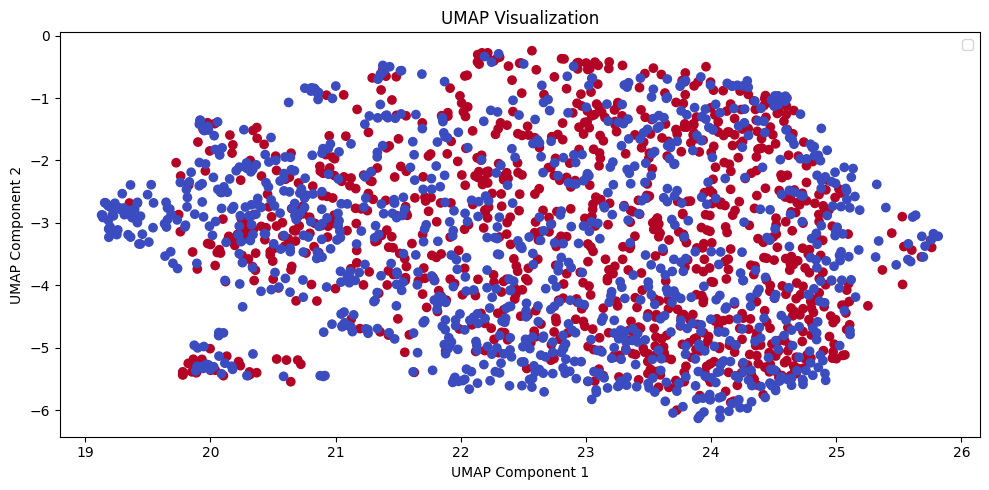

In [22]:
# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(tfidf_matrix.toarray())


# Plot UMAP results
plt.figure(figsize=(10, 5))
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=df['sentiment'].map({'positive': 1, 'negative': 0}), cmap='coolwarm')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.tight_layout()
plt.legend()
plt.show()

# Modeling

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# set up X and y
embeddings = tfidf_matrix.toarray()
labels = encoder.fit_transform(df['sentiment'])

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

#
dataset = IMDBDataset(features=embeddings, labels=labels)

#Split dataset for train and validation
train_size = int(0.8 * len(dataset))
train_indices, val_indices = train_test_split(list(range(len(dataset.labels))),
                                              test_size=len(dataset) - train_size,
                                              stratify=dataset.labels,
                                              random_state=42)

trainset = torch.utils.data.Subset(dataset, train_indices)
valset = torch.utils.data.Subset(dataset, val_indices)

#DataLoader to handle batching and shuffling.
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=50, output_dim=2):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # output_dim=2 for CrossEntropyLoss

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = dataset.features.shape[1]
model = SentimentClassifier(input_dim=input_dim)

In [140]:
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

# Train function
def train_model(model, epochs, train_loader, val_loader, optimizer_name = 'Adam', learning_rate = 0.001, device=None):
  torch.manual_seed(42)
  # Init
  output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
  criterion = nn.CrossEntropyLoss() # we instantiate the loss function
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate) # we instantiate Adam optimizer that takes as inputs the model parameters and learning rate

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  for epoch in tqdm(range(epochs)):
    torch.manual_seed(42)
    # Training loop
    model.train() # always specify that the model is in training mode
    running_loss = 0.0 # init loss
    running_acc = 0.

    # Loop over batches returned by the data loader
    for idx, batch in enumerate(train_loader):

      # get the inputs; batch is a tuple of (inputs, labels)
      inputs, labels = batch
      inputs = inputs.to(device) # put the data on the same device as the model
      labels = labels.to(device)

      # put to zero the parameters gradients at each iteration to avoid accumulations
      optimizer.zero_grad()

      # forward pass + backward pass + update the model parameters
      out = model(x=inputs) # get predictions
      loss = criterion(out, labels) # compute loss
      loss.backward() # compute gradients
      optimizer.step() # update model parameters according to these gradients and our optimizer strategy

      # Iteration train metrics
      running_loss += loss.view(1).item() # extract loss value 
      t_out = output_fn(out.detach()).cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
      t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
      ground_truth = labels.cpu().numpy() # detach the labels from GPU device
      running_acc += get_accuracy(ground_truth, t_out)

    ### Epochs train metrics ###
    acc_train.append(running_acc/len(train_loader))
    loss_train.append(running_loss/len(train_loader))

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval() # put the model in evaluation mode (this prevents the use of dropout layers for instance)

    ### VALIDATION DATA ###
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
          ground_truth = labels.cpu().numpy() # detach the labels from GPU device
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    print('| Epoch: [{}/{}] | Train: Loss {:.4f} Accuracy : {:.4f} '\
        '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))

  return loss_train, loss_valid, acc_train, acc_valid

def test_model(model, test_loader):
  output_fn = torch.nn.Softmax(dim=1)
  model.eval()
  torch.manual_seed(42)
  with torch.no_grad():
    idx = 0
    for batch in test_loader:
      inputs,labels=batch
      inputs=inputs.to(device)
      labels=labels.to(device)
      if idx==0:
        t_out = model(x=inputs)
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out=t_out.argmax(axis=1)
        ground_truth = labels.detach().cpu().numpy()
      else:
        out = model(x=inputs)
        t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
      idx+=1

  return get_accuracy(ground_truth,t_out)

In [139]:
nb_epochs = 15
optimizer = 'Adam'
lr = 0.001

train_loss, val_loss, train_acc, val_acc = train_model(model, nb_epochs, trainloader, valloader, optimizer, lr)

 20%|██        | 3/15 [00:00<00:01, 10.75it/s]

| Epoch: [1/15] | Train: Loss 0.3767 Accuracy : 0.8363 | Val: Loss 0.5164 Accuracy : 0.7375

| Epoch: [2/15] | Train: Loss 0.3694 Accuracy : 0.8438 | Val: Loss 0.5171 Accuracy : 0.7375

| Epoch: [3/15] | Train: Loss 0.3654 Accuracy : 0.8450 | Val: Loss 0.5175 Accuracy : 0.7400

| Epoch: [4/15] | Train: Loss 0.3614 Accuracy : 0.8475 | Val: Loss 0.5178 Accuracy : 0.7400



 60%|██████    | 9/15 [00:00<00:00, 19.66it/s]

| Epoch: [5/15] | Train: Loss 0.3573 Accuracy : 0.8525 | Val: Loss 0.5182 Accuracy : 0.7400

| Epoch: [6/15] | Train: Loss 0.3531 Accuracy : 0.8556 | Val: Loss 0.5190 Accuracy : 0.7375

| Epoch: [7/15] | Train: Loss 0.3490 Accuracy : 0.8581 | Val: Loss 0.5194 Accuracy : 0.7375

| Epoch: [8/15] | Train: Loss 0.3448 Accuracy : 0.8600 | Val: Loss 0.5202 Accuracy : 0.7375

| Epoch: [9/15] | Train: Loss 0.3406 Accuracy : 0.8619 | Val: Loss 0.5206 Accuracy : 0.7375

| Epoch: [10/15] | Train: Loss 0.3365 Accuracy : 0.8669 | Val: Loss 0.5216 Accuracy : 0.7375



100%|██████████| 15/15 [00:00<00:00, 19.30it/s]

| Epoch: [11/15] | Train: Loss 0.3323 Accuracy : 0.8675 | Val: Loss 0.5225 Accuracy : 0.7375

| Epoch: [12/15] | Train: Loss 0.3280 Accuracy : 0.8725 | Val: Loss 0.5235 Accuracy : 0.7375

| Epoch: [13/15] | Train: Loss 0.3236 Accuracy : 0.8769 | Val: Loss 0.5240 Accuracy : 0.7375

| Epoch: [14/15] | Train: Loss 0.3194 Accuracy : 0.8769 | Val: Loss 0.5251 Accuracy : 0.7375

| Epoch: [15/15] | Train: Loss 0.3151 Accuracy : 0.8781 | Val: Loss 0.5259 Accuracy : 0.7400



# Evaluation